In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [3]:
data = pd.read_csv('../data/UCBadmit.csv', sep=';').reset_index(drop=True)

dept_idx = (
    data.dept.drop_duplicates().sort_values().reset_index(drop=True).reset_index()
    .set_index('dept')['index'].rename('dept_i').to_frame()
)

data = pd.merge(
    data,
    dept_idx,
    left_on='dept',
    right_index=True)

data = data.assign(
    is_male=(data['applicant.gender'] == 'male').astype('int'),
    ratio=data.admit / data.applications)

data

,dept,applicant.gender,admit,reject,applications,dept_i,is_male,ratio
0,A,male,512,313,825,0,1,0.620606
1,A,female,89,19,108,0,0,0.824074
2,B,male,353,207,560,1,1,0.630357
3,B,female,17,8,25,1,0,0.680000
4,C,male,120,205,325,2,1,0.369231
5,C,female,202,391,593,2,0,0.340641
6,D,male,138,279,417,3,1,0.330935
7,D,female,131,244,375,3,0,0.349333
8,E,male,53,138,191,4,1,0.277487
9,E,female,94,299,393,4,0,0.239186


**single intercept**

In [4]:
with pm.Model() as model_single_intercept:
    alpha = pm.Normal('alpha', mu=0, sd=1.5)
    
    p = pm.Deterministic('p', pm.math.invlogit(alpha))
    
    admit = pm.Binomial('admit', n=data.applications.values, p=p,
                        observed=data.admit.values)
    
    model_single_intercept.name = 'single intercept'
    model_single_intercept.trace = pm.sample(2000, tune=2000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1827.20draws/s]


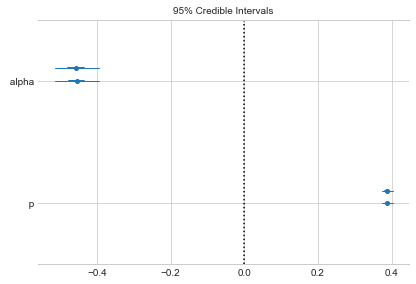

In [6]:
pm.forestplot(model_single_intercept.trace, rhat=False)
None

**gender model**

In [7]:
with pm.Model() as model_gender:
    alpha = pm.Normal('alpha', mu=0, sd=1.5)

    beta_m = pm.Normal('beta_m', mu=0, sd=1)

    logit_p = alpha + beta_m * data.is_male

    p = pm.Deterministic('p', pm.math.invlogit(logit_p))

    admit = pm.Binomial('admit', n=data.applications.values, p=p,
                        observed=data.admit.values)
    
    model_gender.name = 'gender'
    model_gender.trace = pm.sample(2000, tune=2000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_m, alpha]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1147.55draws/s]


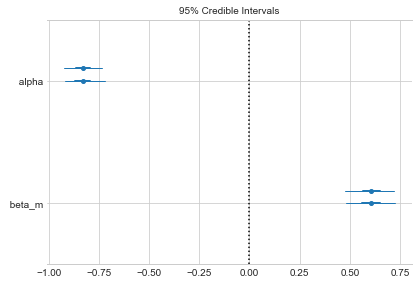

In [8]:
pm.forestplot(model_gender.trace, varnames=['alpha', 'beta_m'], rhat=False)
None

In [9]:
pm.compare({
        model_gender: model_gender.trace,
        model_single_intercept: model_single_intercept.trace,
    },
    method='BB-pseudo-BMA',
)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
gender,984.38,113.01,0,0.65,288.14,0,1
single intercept,1050.27,86.37,65.89,0.35,293.19,158.95,1


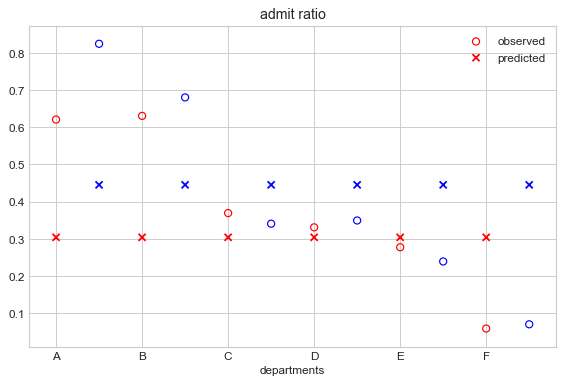

In [26]:
tmp = agg_prediction(model_gender.trace['p'], data, ['dept', 'is_male'], summarize())

fig, ax = plt.subplots(figsize=(8, 5), dpi=85)
color = tmp.is_male.map(lambda is_male: 'b' if is_male else 'r')

ax.scatter(data.index, data.ratio, marker='o', facecolors='none', edgecolors=color, label='observed',)
ax.scatter(tmp.index, tmp.mean_, marker='x', c=color, label='predicted')

ax.set(title='admit ratio', xlabel='departments',
       xticks = range(0, 12, 2), xticklabels=tmp.loc[range(0, 12, 2)].dept)
ax.legend()
None

**department intercepts**

In [27]:
with pm.Model() as model_dept:
    alpha = pm.Normal('dept', mu=0, sd=1.5, shape=data.dept_i.nunique())

    beta_m = pm.Normal('beta_m', mu=0, sd=1)

    _alpha = alpha[data.dept_i.values]
    _logit_p = _alpha + beta_m * data.is_male.values
    
    p = pm.Deterministic('p', pm.math.invlogit(_logit_p))

    admit = pm.Binomial('admit', n=data.applications.values, p=p,
                        observed=data.admit.values)
    
    model_dept.name = 'department'
    model_dept.trace = pm.sample(2000, tune=2000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_m, dept]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:10<00:00, 766.12draws/s]


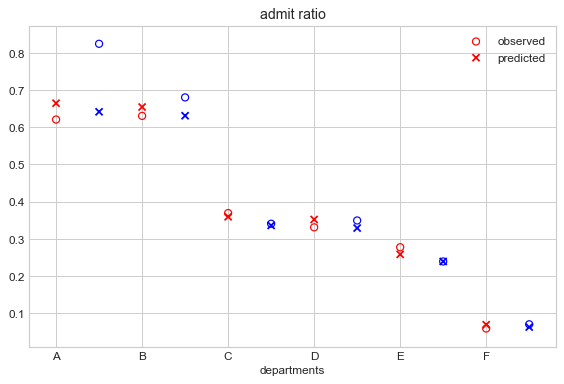

In [28]:
tmp = agg_prediction(model_dept.trace['p'], data, ['dept', 'is_male'], summarize())

fig, ax = plt.subplots(figsize=(8, 5), dpi=85)
color = tmp.is_male.map(lambda is_male: 'b' if is_male else 'r')

ax.scatter(data.index, data.ratio, marker='o', facecolors='none', edgecolors=color, label='observed',)
ax.scatter(tmp.index, tmp.mean_, marker='x', c=color, label='predicted')

ax.set(title='admit ratio', xlabel='departments',
       xticks = range(0, 12, 2), xticklabels=tmp.loc[range(0, 12, 2)].dept)
ax.legend()
None

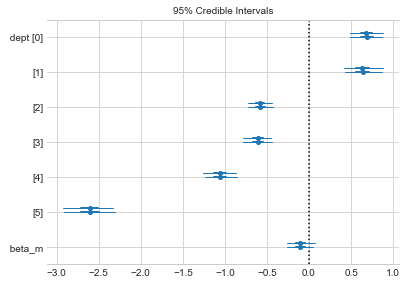

In [29]:
pm.forestplot(model_dept.trace, varnames=['dept', 'beta_m'], rhat=False)
None

In [30]:
pm.compare({
        model_gender: model_gender.trace,
        model_dept: model_dept.trace,
    },
    method='BB-pseudo-BMA'
)   

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
department,108.47,9.41,0,1,14.38,0,1
gender,984.38,113.01,875.92,0,292.81,308.1,1
